In [163]:
# LEAFToolbox-SL2P
#
# Applies the LEAF-ToolBox-SL2P to process input images on Googe Earth Engine
# AND exports to google drive.
# 
# Note: This is an exact copy of LEAF-ToolBox-SL2P for image by image products
# as implemented on February 10, 2021 16:00 EST
# https://code.earthengine.google.com/fd6bddb89803bd8ea45fdcad051f75cc
#
# You will need a Google Earth Engine Account linked to a Google Account with sufficient
# disk space for the output.
#
# Refer to https://github.com/rfernand387/LEAF-Toolbox/tree/master/Source-Python 
# for configuration of anaconda environment.

In [2]:
import ee
import folium
import time
from folium import plugins
import numpy as np
import matplotlib.pyplot as plt
import geopy as gp

In [3]:
ee.Authenticate()

Enter verification code:  4/1AY0e-g6n6RJ-cd0AZ1JT-kjEddBVzbbwuVgxI1yJcUbBdUTm13BCj894r1Y



Successfully saved authorization token.


In [4]:
# Authorizes the script with Earth Engine using the credentials.json file. Ensure either ee.Authenticate() has been called in a previous
# script or the "$ earthengine authenticate" command has been run in the environment to set up the credentials.json file
# The google account you provide during the authentication flow must have received access to Google Earth Engine
ee.Initialize()

In [5]:
def check_ee_tasks(ee_tasks: list = []):
    for task in ee_tasks:
        taskStatus = ee.data.getTaskStatus(task.id)[0]
        print(taskStatus["description"] + ": " + taskStatus["state"])


In [6]:
# Wait loop for Earth Engine tasks to complete. Polls for the task status the specificed number of seconds until it is no longer active
def task_wait_loop(ee_task, wait_interval):
    print(ee.data.getTaskStatus(ee_task.id)[0]["description"]+":", end=" ")
    prev_task_status = ee.data.getTaskStatus(ee_task.id)[0]["state"]
    print(prev_task_status, end=" ")
    while ee_task.active():
        task_status = ee.data.getTaskStatus(ee_task.id)[0]["state"]
        if(task_status != prev_task_status):
            print(task_status, end=" ")
        prev_task_status = task_status
        time.sleep(wait_interval)
    print(ee.data.getTaskStatus(ee_task.id)[0]["state"])

In [7]:
# Create a folium map object.
def displayImage(image,minVal,maxVal) :
    my_map = folium.Map(location=[20, 0], zoom_start=3, height=500)
    vis_params = {
      'min': minVal,
      'max': maxVal}
    my_map.add_ee_layer(image, vis_params, 'Image')
    # Add a layer control panel to the map.
    my_map.add_child(folium.LayerControl())

    # Add fullscreen button
    plugins.Fullscreen().add_to(my_map)

    # Display the map.
    display(my_map)

In [8]:
# Define a method for displaying Earth Engine image tiles on a folium map.
def add_ee_layer(self, ee_object, vis_params, name):
    
    try:    
        # display ee.Image()
        if isinstance(ee_object, ee.image.Image):    
            map_id_dict = ee.Image(ee_object).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.ImageCollection()
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):    
            ee_object_new = ee_object.mosaic()
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.Geometry()
        elif isinstance(ee_object, ee.geometry.Geometry):    
            folium.GeoJson(
            data = ee_object.getInfo(),
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
        # display ee.FeatureCollection()
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):  
            ee_object_new = ee.Image().paint(ee_object, 0, 2)
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
    
    except:
        print("Could not display {}".format(name))
    
# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [9]:
default_asset_location = "users/hemitshah"
def export_collection_to_gee(collection, num_images: int = 0, image_names: list = [], asset_folder: str = default_asset_location, scale: float = 20, max_pixels: int = 1e8, data_type: str = "float"):
    
    collection = ee.ImageCollection(collection)
    
    image_list = collection.toList(num_images)
    task_list = []
    
    for i in range(num_images):
        image = ee.Image(image_list.get(i))
        name = image_names[i]
        
        typed_images = {"double": image.toDouble(), "float": image.toFloat(), "byte": image.toByte(), "int": image.toInt()}
        export_task = ee.batch.Export.image.toAsset(image = typed_images[data_type],
                                                      description = name,
                                                      assetId = asset_folder+"/"+name,
                                                      region = image.geometry(),
                                                      scale = scale,
                                                      maxPixels = max_pixels)
        export_task.start()
        task_list.append(export_task)
    
    return task_list

In [10]:
def export_collection_to_drive(collection, num_images: int = 0, image_names: list = [], gdrive_folder: str = "", scale: float = 20, max_pixels: int = 1e8, data_type: str = "float"):
    
    collection = ee.ImageCollection(collection)
    image_list = collection.toList(num_images)
    task_list = []

    for i in range(num_images):
        image = ee.Image(image_list.get(i))
        name = image_names[i]
        print(name)
        typed_images = {"double": image.toDouble(), "float": image.toFloat(), "byte": image.toByte(), "int": image.toInt()}
        export_task = ee.batch.Export.image.toDrive(image = typed_images[data_type],
                                                    description = name,
                                                    folder = gdrive_folder,
                                                    fileNamePrefix = name,
                                                    region = image.geometry(),
                                                    scale = scale,
                                                    maxPixels = max_pixels)
        export_task.start()
        task_list.append(export_task)
    
    return task_list

In [11]:
def s2_createFeatureCollection_estimates():
    return ee.FeatureCollection('users/rfernand387/COPERNICUS_S2_SR/s2_sl2p_weiss_or_prosail_NNT3_Single_0_1')


In [12]:
def s2_createFeatureCollection_errors():
    return ee.FeatureCollection('users/rfernand387/COPERNICUS_S2_SR/s2_sl2p_weiss_or_prosail_NNT3_Single_0_1_Error')

In [13]:
def s2_createFeatureCollection_domains():
    return ee.FeatureCollection('users/rfernand387/COPERNICUS_S2_SR/weiss_or_prosail3_NNT3_Single_0_1_DOMAIN')

In [14]:
def s2_createFeatureCollection_range():
    return ee.FeatureCollection('users/rfernand387/COPERNICUS_S2_SR/weiss_or_prosail3_NNT3_Single_0_1_RANGE')

In [15]:
def s2_createFeatureCollection_Network_Ind():
    return ee.FeatureCollection('users/rfernand387/COPERNICUS_S2_SR/Parameter_file_sl2p')

In [16]:
def s2_createImageCollection_partition():
    return ee.ImageCollection('users/rfernand387/NA_NALCMS_2015_tiles').map(lambda image: image.select("b1").rename("partition")).merge(ee.ImageCollection("COPERNICUS/Landcover/100m/Proba-V/Global").map( lambda image: image.select("discrete_classification").remap([0,20,30,40,50,60,70,80,90,100,111,112,113,114,115,116,121,122,123,124,125,126,200],[0,8,10,15,17,16,19,18,14,13,1,3,1,5,6,6,2,4,2,5,6,6,18],0).toUint8().rename("partition")))

In [17]:
def s2_createFeatureCollection_legend():
    return ee.FeatureCollection('users/rfernand387/COPERNICUS_S2_SR/Legend_sl2p')

In [18]:
def l8_createFeatureCollection_estimates():
    return ee.FeatureCollection('users/rfernand387/LANDSAT_LC08_C01_T1_SR_SL2P_OUTPUT')

In [19]:
def l8_createFeatureCollection_errors():
    return ee.FeatureCollection('users/rfernand387/LANDSAT_LC08_C01_T1_SR_SL2P_ERRORS')

In [20]:
def l8_createFeatureCollection_domains():
    return ee.FeatureCollection('users/rfernand387/LANDSAT_LC08_C01_T1_SR/LANDSAT_LC08_C01_T1_SR_DOMAIN')

In [21]:
def l8_createFeatureCollection_range():
    return ee.FeatureCollection('users/rfernand387/LANDSAT_LC08_C01_T1_SR/LANDSAT_LC08_C01_T1_SR_RANGE')

In [22]:
def l8_createFeatureCollection_Network_Ind():
    return ee.FeatureCollection('users/rfernand387/LANDSAT_LC08_C01_T1_SR/Parameter_file_sl2p')

In [23]:
def l8_createImageCollection_partition():
    return ee.ImageCollection('users/rfernand387/NA_NALCMS_2015_tiles').map(lambda image: image.select("b1").rename("partition")).merge(ee.ImageCollection("COPERNICUS/Landcover/100m/Proba-V/Global").map( lambda image: image.select("discrete_classification").remap([0,20,30,40,50,60,70,80,90,100,111,112,113,114,115,116,121,122,123,124,125,126,200],[0,8,10,15,17,16,19,18,14,13,1,3,1,5,6,6,2,4,2,5,6,6,18],0).toUint8().rename("partition")))

In [24]:
def l8_createFeatureCollection_legend():
    return ee.FeatureCollection('users/rfernand387/LANDSAT_LC08_C01_T1_SR/Legend_sl2p')

In [25]:
# add a 'date' band: number of days since epoch
def addDate(image):
    return image.addBands(ee.Image.constant(ee.Date(image.date()).millis().divide(86400000)).rename('date').toUint16())

In [26]:
#computes a delta time property for an image
def deltaTime(midDate,image) :
    return ee.Image(image.set("deltaTime",ee.Number(image.date().millis()).subtract(ee.Number(midDate)).abs()))

In [27]:
# mask pixels that are not clear sky in a S2 MSI image
def s2MaskClear(image) :
    qa = image.select('QA60');
    mask = qa.bitwiseAnd(1<<10).eq(0).And(qa.bitwiseAnd(1<<11).eq(0));
    return image.updateMask(mask)

In [28]:
# add s2 geometry bands scaled by 10000
def addS2Geometry(colOptions,image) :
    return (image.addBands(image.metadata(colOptions["vza"]).multiply(3.1415).divide(180).cos().multiply(10000).toUint16().rename(['cosVZA']))
              .addBands(image.metadata(colOptions["sza"]).multiply(3.1415).divide(180).cos().multiply(10000).toUint16().rename(['cosSZA']))
              .addBands(image.metadata(colOptions["saa"]).subtract(image.metadata(colOptions["saa"])).multiply(3.1415).divide(180).cos().multiply(10000).toInt16().rename(['cosRAA'])));

In [29]:
# sentinel 2 land mask
def s2MaskLand(image) :
    return image.updateMask((image.select('SCL').eq(4)).Or(image.select('SCL').eq(5)))

In [30]:
# returns image with selected bands scaled
def scaleBands(bandList,scaleList,image) :
    bandList = ee.List(bandList)
    scaleList = ee.List(scaleList)
    return image.addBands(srcImg = image.select(bandList).multiply(ee.Image.constant(scaleList)).rename(bandList),overwrite = True)

In [31]:
# Determine if inputs fall in domain of algorithm
# Need to be updated to allow for the domain to vary with partition
def invalidInput(sl2pDomain,bandList,image) :
    
    sl2pDomain =  ee.FeatureCollection(sl2pDomain).aggregate_array("DomainCode").sort()
    bandList = ee.List(bandList).slice(3)
    image = ee.Image(image)

    # code image bands into a single band and compare to valid codes to make QC band
    image = image.addBands(image.select(bandList)
                              .multiply(ee.Image.constant(ee.Number(10)))
                              .ceil()
                              .mod(ee.Number(10))
                              .uint8()
                              .multiply(ee.Image.constant(ee.List.sequence(0,bandList.length().subtract(1)).map(lambda value: ee.Number(10).pow(ee.Number(value)))))
                              .reduce("sum")  
                              .remap(sl2pDomain, ee.List.repeat(0, sl2pDomain.length()),1)
                              .rename("QC"))
    return image




In [32]:
# returns image with single band named network id corresponding given 
def makeIndexLayer(image,legend,Network_Ind) :
    
    image = ee.Image(image)                        # partition image
    legend = ee.FeatureCollection(legend)          # legend to convert partition numbers to networks
    Network_Ind = ee.FeatureCollection(Network_Ind) # legend to convert networks to networkIDs
    
    #get lists of valid partitions
    legend_list = legend.toList(legend.size())
    landcover= legend_list.map(lambda feature: ee.Feature(feature).getNumber('Value'))

    # get corresponding networkIDs
    networkIDs = legend_list.map(lambda feature: ee.Feature(feature).get('SL2P Network')) \
                              .map(lambda propertyValue:  ee.Feature(ee.FeatureCollection(Network_Ind).first()).toDictionary().getNumber(propertyValue))
    
    return image.remap(landcover, networkIDs, 0).rename('networkID')

In [33]:
# Read coefficients of a network from csv EE asset
def getCoefs(netData,ind) :
    return((ee.Feature(netData)).getNumber(ee.String('tabledata').cat(ee.Number(ind).int().format())))

In [34]:
# Parse one row of CSV file for a network into a global variable
#
# We assume a two hidden layer network with tansig functions but
# allow for variable nodes per layer
def makeNets(feature, M) :
    
    feature = ee.List(feature);
    M = ee.Number(M);
    
    # get the requested network and initialize the created network
    netData = ee.Feature(feature.get(M.subtract(1)));
    net = {};
    
    # input slope
    num = ee.Number(6);
    start = num.add(1);
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())));
    net["inpSlope"] = ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind))
    
    # input offset
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())))
    net["inpOffset"] = ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind))

    # hidden layer 1 weight
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())))
    net["h1wt"] = ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind))

    # hidden layer 1 bias
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())))
    net["h1bi"] = ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind))

    # hidden layer 2 weight
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())))
    net["h2wt"] = ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind))
  
    # hidden layer 2 bias
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())))
    net["h2bi"] = ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind))

    # output slope
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())))
    net["outSlope"] = ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind))
  
    # output offset
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())))
    net["outBias"] = ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind))
    
    return(ee.Dictionary(net))


In [35]:
# Parse CSV file with list of networks for a selected variable  
#This will parse one network for each landclass partition
def makeNetVars(asset, numNets, variableNum) :
    
    asset= ee.FeatureCollection(asset)
    numNets = ee.Number(numNets)
    variableNum= ee.Number(variableNum)  

    #get selected network 
    list_features = asset.flatten()
    filtered_features = ee.FeatureCollection(asset.filter(ee.Filter.eq('tabledata3', variableNum))).toList(numNets)
    
    return ee.List.sequence(1,numNets).map(lambda netNum: makeNets(filtered_features,netNum))


In [36]:
# returns dictionary with image masked so the networkID band equals the netIndex and the corresponding network
def selectNet(image,netList,inputNames,netIndex) :
    
    image = ee.Image(image)
    netList = ee.List(netList)
    inputNames = ee.List(inputNames)
    netIndex = ee.Number(netIndex).int()
    
    return ee.Dictionary()  \
            .set("Image", ee.Image(image.updateMask(image.select('networkID').eq(netIndex)).select(inputNames))) \
            .set("Network", ee.List(netList.get(netIndex))) 

In [37]:
# applies two layer neural network within input and output scaling
def applyNet(outputName,netDict) :
    
    outputName = ee.String(outputName)
    netDict = ee.Dictionary(netDict)
    
    inp = ee.Image(netDict.get('Image'))
    net = ee.Dictionary(netDict.get('Network'))
    
    # Input scaling
    l1inp2D = inp.multiply(ee.Image(net.toArray(ee.List(['inpSlope']),0).transpose()) \
                                          .arrayProject([0]) \
                                          .arrayFlatten([inp.bandNames()])) \
                   .add(ee.Image(net.toArray(ee.List(['inpOffset']),0).transpose()) \
                                          .arrayProject([0]) \
                                          .arrayFlatten([inp.bandNames()]))
    
    # Hidden layers
    l12D = ee.Image(net.toArray(ee.List(['h1wt']),0).reshape([ee.List(net.get('h1bi')).length(),ee.List(net.get('inpOffset')).length()])) \
              .matrixMultiply(l1inp2D.toArray().toArray(1)) \
              .add(ee.Image(net.toArray(ee.List(['h1bi']),0).transpose())) \
              .arrayProject([0]).arrayFlatten([['h1w1','h1w2','h1w3','h1w4','h1w5']])
    
    # apply tansig 2/(1+exp(-2*n))-1
    l2inp2D = ee.Image(2).divide(ee.Image(1).add((ee.Image(-2).multiply(l12D)).exp())).subtract(ee.Image(1))
    
    # purlin hidden layers
    l22D = l2inp2D.multiply(ee.Image(net.toArray(ee.List(['h2wt']),0).transpose()) \
                                          .arrayProject([0]) \
                                          .arrayFlatten([['h2w1','h2w2','h2w3','h2w4','h2w5']])) \
                    .reduce('sum') \
                    .add(ee.Image(net.toArray(ee.List(['h2bi']),0))) \
                                          .arrayProject([0]) \
                                          .arrayFlatten([['h2bi']])
    
    # Output scaling 
    outputBand = l22D.subtract(ee.Image(ee.Number(net.get('outBias')))) \
                    .divide(ee.Image(ee.Number(net.get('outSlope')))) 
    
    # Return network output
    return (outputBand.rename(outputName))

In [38]:
# returns image with single band named networkid corresponding given 
# input partition image remapped to networkIDs
# applies a set of shallow networks to an image based on a provided partition image band
def wrapperNNets(network, partition, netOptions, colOptions, suffixName, imageInput) :

    # typecast function parameters
    network = ee.List(network)
    partition = ee.Image(partition)
    netOptions = netOptions
    colOptions = colOptions
    suffixName = suffixName
    imageInput = ee.Image(imageInput)

    # parse partition  used to identify network to use
    partition = partition.clip(imageInput.geometry()).select(['partition'])

    # determine networks based on collection
    netList = ee.List(network.get(ee.Number(netOptions.get("variable")).subtract(1))); 
    
    # parse land cover into network index and add to input image
    imageInput = imageInput.addBands(makeIndexLayer(partition,colOptions["legend"],colOptions["Network_Ind"]))

    # define list of input names
    return ee.ImageCollection(ee.List.sequence(0, netList.size().subtract(1)) \
                                                    .map(lambda netIndex: selectNet(imageInput,netList,netOptions["inputBands"],netIndex)) \
                                                    .map(lambda netDict: applyNet(suffixName+outputName,netDict))) \
                                .max() \
                  .addBands(partition) \
                  .addBands(imageInput.select('networkID'))

In [39]:
# returns dictionary with image masked so the networkID band equals the netIndex and the corresponding network
def selectNet2(image,netList,inputNames,netIndex) :
    
    image = ee.Image(image)
    netList = ee.List(netList)
    inputNames = ee.List(inputNames)
    netIndex = ee.Number(netIndex).int()
    result = ee.Dictionary()  \
            .set("Image", ee.Image(image.updateMask(image.select('networkID').eq(netIndex)).select(inputNames))) \
            .set("Network", ee.List(netList.get(netIndex)))
    return result

In [40]:
# applies two layer neural network within input and output scaling
def applyNet2(outputName,netDict) :
    
    outputName = ee.String(outputName)
    netDict = ee.Dictionary(netDict)
    inp = ee.Image(netDict.get('Image'))
    net = ee.Dictionary(netDict.get('Network'))
    
    # Input scaling
    l1inp2D = inp.multiply(ee.Image(net.toArray(ee.List(['inpSlope']),0).transpose()) \
                                          .arrayProject([0]) \
                                          .arrayFlatten([inp.bandNames()])) \
                   .add(ee.Image(net.toArray(ee.List(['inpOffset']),0).transpose()) \
                                          .arrayProject([0]) \
                                          .arrayFlatten([inp.bandNames()]))

    # Hidden layers
    l12D = ee.Image(net.toArray(ee.List(['h1wt']),0).reshape([ee.List(net.get('h1bi')).length(),ee.List(net.get('inpOffset')).length()])) \
              .matrixMultiply(l1inp2D.toArray().toArray(1)) \
              .add(ee.Image(net.toArray(ee.List(['h1bi']),0).transpose())) \
              .arrayProject([0]).arrayFlatten([['h1w1','h1w2','h1w3','h1w4','h1w5']])
    
    # apply tansig 2/(1+exp(-2*n))-1
    l2inp2D = ee.Image(2).divide(ee.Image(1).add((ee.Image(-2).multiply(l12D)).exp())).subtract(ee.Image(1))
    
    # purlin hidden layers
    l22D = l2inp2D.multiply(ee.Image(net.toArray(ee.List(['h2wt']),0).transpose()) \
                                          .arrayProject([0]) \
                                          .arrayFlatten([['h2w1','h2w2','h2w3','h2w4','h2w5']])) \
                    .reduce('sum') \
                    .add(ee.Image(net.toArray(ee.List(['h2bi']),0))) \
                                          .arrayProject([0]) \
                                          .arrayFlatten([['h2bi']])
    
    # Output scaling 
    outputBand = l22D.subtract(ee.Image(ee.Number(net.get('outBias')))) \
                    .divide(ee.Image(ee.Number(net.get('outSlope')))) 

    # Return network output
    return (outputBand.rename(outputName))

In [41]:
# Read coefficients of a network from csv EE asset
def getCoefs2(netData,ind) :
    return((ee.Feature(netData)).getNumber(ee.String('tabledata').cat(ee.Number(ind).int().format())))

In [42]:
# Parse one row of CSV file for a network into a global variable
#
# We assume a two hidden layer network with tansig functions but
# allow for variable nodes per layer
def makeNets2(feature, M) :
    
    feature = ee.List(feature);
    M = ee.Number(M);
    
    # get the requested network and initialize the created network
    netData = ee.Feature(feature.get(M.subtract(1)));
    net = ee.Dictionary();
    
    # input slope
    num = ee.Number(6);
    start = num.add(1);
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())));
    net = net.set("inpSlope", ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind)))
    
    # input offset
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())));
    net = net.set("inpOffset", ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind)))

    # hidden layer 1 weight
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())));
    net = net.set("h1wt", ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind)))

    # hidden layer 1 bias
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())));
    net = net.set("h1bi", ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind)))

    # hidden layer 2 weight
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())));
    net = net.set("h2wt", ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind)))
  
    # hidden layer 2 bias
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())));
    net = net.set("h2bi", ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind)))

    # output slope
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())));
    net = net.set("outSlope", ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind)))
  
    # output offset
    num = end.add(1)
    start = num.add(1)
    end = num.add(netData.getNumber(ee.String('tabledata').cat(num.format())));
    net = net.set("outBias", ee.List.sequence(start,end).map(lambda ind: getCoefs(netData,ind)))

    return(net)


In [43]:
# Parse CSV file with list of networks for a selected variable  
#This will parse one network for each landclass partition
def makeNetVars2(asset, numNets, variableNum) :
    
    asset= ee.FeatureCollection(asset)
    numNets = ee.Number(numNets)
    variableNum= ee.Number(variableNum)
    

    #get selected network 
    filtered_features = ee.FeatureCollection(asset.filter(ee.Filter.eq('tabledata3', variableNum))).toList(numNets)
    
    # make only first net
    netList = makeNets2(filtered_features,1)
    return netList
    #return ee.List.sequence(1,numNets).map(lambda netNum: makeNets(filtered_features,netNum))


In [44]:
# returns image with single band named networkid corresponding given 
# input partition image remapped to networkIDs
# applies a set of shallow networks to an image based on a provided partition image band
def wrapperNNets2(network, partition, netOptions, colOptions, layerName, imageInput) :

    # typecast function parameters
    network = ee.List(network)
    partition = ee.Image(partition)
    netOptions = ee.Dictionary(netOptions)
    colOptions = ee.Dictionary(colOptions)
    layerName = ee.String(layerName)
    imageInput = ee.Image(imageInput)

    # parse partition  used to identify network to use
    partition = partition.clip(imageInput.geometry()).select(['partition'])

    # determine networks based on collection
    netList = ee.List(network.get(ee.Number(netOptions.get("variable")).subtract(1))) 
    
    # parse land cover into network index and add to input image
    imageInput = imageInput.addBands(makeIndexLayer2(partition,colOptions.get("legend"),colOptions.get("Network_Ind")))


    # define list of input names
    netIndex = 0;
    netDict = ee.Dictionary(selectNet2(imageInput,netList,netOptions.get("inputBands"),netIndex));
    estimate = ee.Image(applyNet2(layerName,netDict))

    return estimate.addBands(partition).addBands(imageInput.select('networkID'))

In [45]:
COLLECTION_OPTIONS = {
    'COPERNICUS/S2_SR': {
      "name": 'S2',
      "description": 'Sentinel 2A',
      "Cloudcover": 'CLOUDY_PIXEL_PERCENTAGE',
      "Watercover": 'WATER_PERCENTAGE',
      "sza": 'MEAN_SOLAR_ZENITH_ANGLE',
      "vza": 'MEAN_INCIDENCE_ZENITH_ANGLE_B8A',
      "saa": 'MEAN_SOLAR_AZIMUTH_ANGLE', 
      "vaa": 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B8A',
      "VIS_OPTIONS": 'VIS_OPTIONS',
      "Collection_SL2P": ee.FeatureCollection(s2_createFeatureCollection_estimates()),
      "Collection_SL2Perrors": ee.FeatureCollection(s2_createFeatureCollection_errors()),  
      "sl2pDomain": ee.FeatureCollection(s2_createFeatureCollection_domains()),
      "Network_Ind": ee.FeatureCollection(s2_createFeatureCollection_Network_Ind()),
      "partition": ee.ImageCollection(s2_createImageCollection_partition()),
      "legend":  ee.FeatureCollection(s2_createFeatureCollection_legend()),
      "numVariables": 7
    },
    'LANDSAT/LC08/C01/T1_SR': {
      "name": 'L8',
      "description": 'LANDSAT 8',
      "Cloudcover": 'CLOUD_COVER_LAND',
      "Watercover": 'CLOUD_COVER',
      "sza": 'SOLAR_ZENITH_ANGLE',
      "vza": 'SOLAR_ZENITH_ANGLE',
      "saa": 'SOLAR_AZIMUTH_ANGLE', 
      "vaa": 'SOLAR_AZIMUTH_ANGLE',
      "VIS_OPTIONS": 'VIS_OPTIONS',
      "Collection_SL2P": ee.FeatureCollection(l8_createFeatureCollection_estimates()),
      "Collection_SL2Perrors": ee.FeatureCollection(l8_createFeatureCollection_errors()),
      "sl2pDomain": ee.FeatureCollection(l8_createFeatureCollection_domains()),
      "Network_Ind": ee.FeatureCollection(l8_createFeatureCollection_Network_Ind()),
      "partition": ee.ImageCollection(l8_createImageCollection_partition()),
      "legend":  ee.FeatureCollection(l8_createFeatureCollection_legend()),
      "numVariables": 7
    }
}
VIS_OPTIONS = {
    "Surface_Reflectance": {
        "COPERNICUS/S2_SR": {
            "Name": 'Surface_Reflectance',
            "description": 'Surface_Reflectance',
            "inp":      [ 'B4', 'B5', 'B6', 'B7', 'B8A','B9','B11','B12']
        }
      },
    "Albedo": {
        "COPERNICUS/S2_SR": {
            "Name": 'Albedo',
            "errorName": 'errorAlbedo',
            "maskName": 'maskAlbedo',
            "description": 'Black sky albedo',
            "variable": 6,
            "inputBands":      [ 'cosVZA','cosSZA','cosRAA','B3','B4', 'B5', 'B6', 'B7', 'B8A','B11','B12'],
            "inputScaling":      [0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        }
    },
    'fAPAR': {
        "COPERNICUS/S2_SR": {
            "Name": 'fAPAR',
            "errorName": 'errorfAPAR',
            "maskName": 'maskfAPAR',
            "description": 'Fraction of absorbed photosynthetically active radiation',
            "variable": 2,
            "inputBands":      [ 'cosVZA','cosSZA','cosRAA','B3','B4', 'B5', 'B6', 'B7', 'B8A','B11','B12'],
            "inputScaling":      [0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
      }
    },
    'fCOVER': {
        "COPERNICUS/S2_SR": {
            "Name": 'fCOVER',
            "errorName": 'errorfCOVER',
            "maskName": 'maskfCOVER',
            "description": 'Fraction of canopy cover',
            "variable": 3,
            "inputBands":      [ 'cosVZA','cosSZA','cosRAA','B3','B4', 'B5', 'B6', 'B7', 'B8A','B11','B12'],
            "inputScaling":      [0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]]))) 
      }
    },
    'LAI': {
        "COPERNICUS/S2_SR": {
            "Name": 'LAI',
            "errorName": 'errorLAI',
            "maskName": 'maskLAI',
            "description": 'Leaf area index',
            "variable": 1,
            "inputBands":      [ 'cosVZA','cosSZA','cosRAA','B3','B4', 'B5', 'B6', 'B7', 'B8A','B11','B12'],
            "inputScaling":      [0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
      }  
    },
    'CCC': {
        "COPERNICUS/S2_SR": {
            "Name": 'CCC',
            "errorName": 'errorCCC',
            "maskName": 'maskCCC',
            "description": 'Canopy chlorophyll content',
            "variable": 4,
            "inputBands":      [ 'cosVZA','cosSZA','cosRAA','B3','B4', 'B5', 'B6', 'B7', 'B8A','B11','B12'],
            "inputScaling":      [0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1000]])))
      } 
    },
    'CWC': {
        "COPERNICUS/S2_SR": {
            "Name": 'CWC',
            "errorName": 'errorCWC',
            "maskName": 'maskCWC',
            "description": 'Canopy water content',
            "variable": 5,
            "inputBands":      [ 'cosVZA','cosSZA','cosRAA','B3','B4', 'B5', 'B6', 'B7', 'B8A','B11','B12'],
            "inputScaling":      [0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[100]])))
      } 
    },
    'DASF': {
        "COPERNICUS/S2_SR": {
            "Name": 'DASF',
            "errorName": 'errorDASF',
            "maskName": 'maskDASF',
            "description": 'Directional area scattering factor',
            "variable": 1,
            "inputBands":      [ 'cosVZA','cosSZA','cosRAA','B3','B4', 'B5', 'B6', 'B7', 'B8A','B11','B12'],
            "inputScaling":      [0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
      } 
    }
}

In [46]:
# returns lists of sampled values for each band in an image as a new feature property
def sampleProduct(image, scaleSample, filterSize,sampleRegion, sampleName) :
    
    # cast vars
    image = ee.Image(image)
    scaleSample= ee.Number(scaleSample)
    sampleRegion = ee.Feature(sampleRegion)
    filterSize = ee.Number(filterSize)
    
    # Define a boxcar or low-pass kernel.
    boxcar = ee.Kernel.square(radius= filterSize, units= 'meters', normalize= True);

    # produce feature collection where each feature is a list of samples from a given band
    sampleData = image.convolve(boxcar).sample(region=sampleRegion.geometry(), projection=image.projection(), scale=scaleSample ,geometries=True)
    #print(sampleData)
    # for each band get a dictionary of sampled values as a property of the sampleRegion feature
    
    sampleList= ee.List(image.bandNames().map(lambda bandName: ee.Dictionary({ 'bandName': bandName, 'data': sampleData.aggregate_array(bandName)})))
    
    return sampleRegion.set(sampleName,sampleList)

In [67]:
# input parameters
plotFeatures = ee.FeatureCollection("users/hemitshah/WP3/CCRSInSituLAI2020").map(lambda feature: feature.buffer(100))
sampleFeatures = ee.FeatureCollection("users/hemitshah/WP3/CCRSInSituLAI2020").map(lambda feature: feature.buffer(60))


# collection name
colName = "COPERNICUS/S2_SR"

# product name, one of('Surface_Reflectance','Albedo','FAPAR','FCOVER','LAI','CCC','CWC','DASF')
outputName = "LAI"

# date range for inputs
startDate = ee.Date('2020-07-01')
endDate = ee.Date('2020-07-28')

# geographical bounds of inputs you can specify a JSON geometry (e.g. from earth engine)
mapBounds = plotFeatures.geometry()

# other filters - for now only cloud cover
maxCloudcover = 90

#product scaling
outputScale = 1000;
outputOffset = 0;

# parse the networks
colOptions = COLLECTION_OPTIONS[colName]
netOptions = VIS_OPTIONS[outputName][colName]
numNets = ee.Number(ee.Feature((COLLECTION_OPTIONS[colName]["Network_Ind"]).first()).propertyNames().remove('Feature Index').remove('system:index').remove('lon').size())
#SL2P1 = makeNetVars2(COLLECTION_OPTIONS[colName]["Collection_SL2P"],numNets,1)
SL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2P"],numNets,netNum));
errorsSL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2Perrors"],numNets,netNum));

In [68]:
# make products 
input_collection =  ee.ImageCollection(colName) \
                      .filterBounds(mapBounds) \
                      .filterDate(startDate, endDate) \
                      .filterMetadata(colOptions["Cloudcover"],'less_than',maxCloudcover) \
                      .limit(5000) \
                      .map(lambda image: addDate(image)) \
                      .map(lambda image: image.clip(mapBounds)) \
                      .map(lambda image: s2MaskClear(image)) \
                      .map(lambda image: addS2Geometry(colOptions,image))
print(input_collection.size().getInfo())

if outputName == "Surface_Reflectance":
    export_collection = input_collection;
    displayImage(export_collection.mosaic().select("B3"),0,4000)    
else:
    # get partition used to select network
    partition = (COLLECTION_OPTIONS[colName]["partition"]).filterBounds(mapBounds).mosaic().clip(mapBounds).rename('partition');
    # pre process input imagery and flag invalid inputs
    input_collection  =  input_collection.map(lambda image: s2MaskLand(image)) \
                                         .map(lambda image: scaleBands(netOptions["inputBands"],netOptions["inputScaling"],image)) \
                                         .map(lambda image: invalidInput(COLLECTION_OPTIONS[colName]["sl2pDomain"],netOptions["inputBands"],image))
    ## apply networks to produce mapped parameters
    estimateSL2P = input_collection.map(lambda image: wrapperNNets(SL2P,partition, netOptions, COLLECTION_OPTIONS[colName],"estimate",image))
    uncertaintySL2P = input_collection.map(lambda image: wrapperNNets(errorsSL2P,partition, netOptions, COLLECTION_OPTIONS[colName],"error",image))
    # scale and offset mapped parameter bands
    estimateSL2P = estimateSL2P.map(lambda image: image.addBands(image.select("estimate"+outputName).multiply(ee.Image.constant(outputScale)).add(ee.Image.constant(outputOffset)),overwrite=True));
    uncertaintySL2P = uncertaintySL2P.map(lambda image: image.addBands(image.select("error"+outputName).multiply(ee.Image.constant(outputScale)).add(ee.Image.constant(outputOffset)),overwrite=True));
    # produce final collection
    export_collection =  input_collection.select(['date','QC']).combine(estimateSL2P).combine(uncertaintySL2P)




12


In [69]:
# extract product values for each image for a feature
scaleSample = 20
filterSize = 60
image= export_collection.mosaic()
sampleFeatures = sampleFeatures.map( lambda sampleRegion: sampleProduct(image, scaleSample, filterSize, sampleRegion,'sampleLAI3x3'))

In [70]:
# input parameters
# collection name
colName = "COPERNICUS/S2_SR"

# product name, one of('Surface_Reflectance','Albedo','FAPAR','FCOVER','LAI','CCC','CWC','DASF')
outputName = "fAPAR"

# date range for inputs
startDate = ee.Date('2020-07-01')
endDate = ee.Date('2020-07-28')
# geographical bounds of inputs you can specify a JSON geometry (e.g. from earth engine)
#sampleFeatures = ee.FeatureCollection("users/hemitshah/WP3/CCRSInSituLAI2020").map(lambda feature: feature.buffer(100))
mapBounds = sampleFeatures.geometry()

# other filters - for now only cloud cover
maxCloudcover = 90

# Output parameters , outputScale and outputOffset not applied to "Surface_Reflectance"
outputScale = 1000;
outputOffset = 0;
exportFolder="users/hemitshah/ExportedData"
exportScale = 20
exportDatatype = "int"

# parse the networks
colOptions = COLLECTION_OPTIONS[colName]
netOptions = VIS_OPTIONS[outputName][colName]
numNets = ee.Number(ee.Feature((COLLECTION_OPTIONS[colName]["Network_Ind"]).first()).propertyNames().remove('Feature Index').remove('system:index').remove('lon').size())
#SL2P1 = makeNetVars2(COLLECTION_OPTIONS[colName]["Collection_SL2P"],numNets,1)
SL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2P"],numNets,netNum));
errorsSL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2Perrors"],numNets,netNum));

In [73]:
# make products 
input_collection =  ee.ImageCollection(colName) \
                      .filterBounds(mapBounds) \
                      .filterDate(startDate, endDate) \
                      .filterMetadata(colOptions["Cloudcover"],'less_than',maxCloudcover) \
                      .limit(5000) \
                      .map(lambda image: addDate(image)) \
                      .map(lambda image: image.clip(mapBounds)) \
                      .map(lambda image: s2MaskClear(image)) \
                      .map(lambda image: addS2Geometry(colOptions,image))
print(input_collection.size().getInfo())

if outputName == "Surface_Reflectance":
    export_collection = input_collection;
    displayImage(export_collection.mosaic().select("B3"),0,4000)    
else:
    # get partition used to select network
    partition = (COLLECTION_OPTIONS[colName]["partition"]).filterBounds(mapBounds).mosaic().clip(mapBounds).rename('partition');
    # pre process input imagery and flag invalid inputs
    input_collection  =  input_collection.map(lambda image: s2MaskLand(image)) \
                                         .map(lambda image: scaleBands(netOptions["inputBands"],netOptions["inputScaling"],image)) \
                                         .map(lambda image: invalidInput(COLLECTION_OPTIONS[colName]["sl2pDomain"],netOptions["inputBands"],image))
    ## apply networks to produce mapped parameters
    estimateSL2P = input_collection.map(lambda image: wrapperNNets(SL2P,partition, netOptions, COLLECTION_OPTIONS[colName],"estimate",image))
    uncertaintySL2P = input_collection.map(lambda image: wrapperNNets(errorsSL2P,partition, netOptions, COLLECTION_OPTIONS[colName],"error",image))
    # scale and offset mapped parameter bands
    estimateSL2P = estimateSL2P.map(lambda image: image.addBands(image.select("estimate"+outputName).multiply(ee.Image.constant(outputScale)).add(ee.Image.constant(outputOffset)),overwrite=True));
    uncertaintySL2P = uncertaintySL2P.map(lambda image: image.addBands(image.select("error"+outputName).multiply(ee.Image.constant(outputScale)).add(ee.Image.constant(outputOffset)),overwrite=True));
    # produce final export collection
    export_collection =  input_collection.select(['date','QC']).combine(estimateSL2P).combine(uncertaintySL2P)
    #displayImage(export_collection.mosaic().select("estimate"+outputName),0+outputOffset,1*outputScale+outputOffset)    
image_output_names = ([name+"_"+outputName for name in export_collection.toList(export_collection.size()).map(lambda image: ee.Image(image).id()).getInfo()])


12


In [74]:
# extract product values for each image for a feature
scaleSample = 20
filterSize = 60
image= export_collection.mosaic()
sampleFeatures = sampleFeatures.map( lambda sampleRegion: sampleProduct(image, scaleSample, filterSize, sampleRegion,'samplefAPAR3x3'))

In [75]:
# input parameters
# collection name
colName = "COPERNICUS/S2_SR"

# product name, one of('Surface_Reflectance','Albedo','FAPAR','FCOVER','LAI','CCC','CWC','DASF')
outputName = "fCOVER"

# date range for inputs
startDate = ee.Date('2020-07-01')
endDate = ee.Date('2020-07-28')
# geographical bounds of inputs you can specify a JSON geometry (e.g. from earth engine)
#sampleFeatures = ee.FeatureCollection("users/hemitshah/WP3/CCRSInSituLAI2020").map(lambda feature: feature.buffer(100))
mapBounds = sampleFeatures.geometry()

# other filters - for now only cloud cover
maxCloudcover = 90

# Output parameters , outputScale and outputOffset not applied to "Surface_Reflectance"
outputScale = 1000;
outputOffset = 0;
exportFolder="users/hemitshah/ExportedData"
exportScale = 20
exportDatatype = "int"

# parse the networks
colOptions = COLLECTION_OPTIONS[colName]
netOptions = VIS_OPTIONS[outputName][colName]
numNets = ee.Number(ee.Feature((COLLECTION_OPTIONS[colName]["Network_Ind"]).first()).propertyNames().remove('Feature Index').remove('system:index').remove('lon').size())
#SL2P1 = makeNetVars2(COLLECTION_OPTIONS[colName]["Collection_SL2P"],numNets,1)
SL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2P"],numNets,netNum));
errorsSL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2Perrors"],numNets,netNum));

In [76]:
# make products 
input_collection =  ee.ImageCollection(colName) \
                      .filterBounds(mapBounds) \
                      .filterDate(startDate, endDate) \
                      .filterMetadata(colOptions["Cloudcover"],'less_than',maxCloudcover) \
                      .limit(5000) \
                      .map(lambda image: addDate(image)) \
                      .map(lambda image: image.clip(mapBounds)) \
                      .map(lambda image: s2MaskClear(image)) \
                      .map(lambda image: addS2Geometry(colOptions,image))
print(input_collection.size().getInfo())

if outputName == "Surface_Reflectance":
    export_collection = input_collection;
    displayImage(export_collection.mosaic().select("B3"),0,4000)    
else:
    # get partition used to select network
    partition = (COLLECTION_OPTIONS[colName]["partition"]).filterBounds(mapBounds).mosaic().clip(mapBounds).rename('partition');
    # pre process input imagery and flag invalid inputs
    input_collection  =  input_collection.map(lambda image: s2MaskLand(image)) \
                                         .map(lambda image: scaleBands(netOptions["inputBands"],netOptions["inputScaling"],image)) \
                                         .map(lambda image: invalidInput(COLLECTION_OPTIONS[colName]["sl2pDomain"],netOptions["inputBands"],image))
    ## apply networks to produce mapped parameters
    estimateSL2P = input_collection.map(lambda image: wrapperNNets(SL2P,partition, netOptions, COLLECTION_OPTIONS[colName],"estimate",image))
    uncertaintySL2P = input_collection.map(lambda image: wrapperNNets(errorsSL2P,partition, netOptions, COLLECTION_OPTIONS[colName],"error",image))
    # scale and offset mapped parameter bands
    estimateSL2P = estimateSL2P.map(lambda image: image.addBands(image.select("estimate"+outputName).multiply(ee.Image.constant(outputScale)).add(ee.Image.constant(outputOffset)),overwrite=True));
    uncertaintySL2P = uncertaintySL2P.map(lambda image: image.addBands(image.select("error"+outputName).multiply(ee.Image.constant(outputScale)).add(ee.Image.constant(outputOffset)),overwrite=True));
    # produce final export collection
    export_collection =  input_collection.select(['date','QC']).combine(estimateSL2P).combine(uncertaintySL2P)
    #displayImage(export_collection.mosaic().select("estimate"+outputName),0+outputOffset,1*outputScale+outputOffset)    
image_output_names = ([name+"_"+outputName for name in export_collection.toList(export_collection.size()).map(lambda image: ee.Image(image).id()).getInfo()])



12


In [77]:
# extract product values for each image for a feature
scaleSample = 20
filterSize = 60
image= export_collection.mosaic()
sampleFeatures = sampleFeatures.map( lambda sampleRegion: sampleProduct(image, scaleSample, filterSize, sampleRegion,'samplefCOVER3x3'))

In [78]:
dataCCRS2020 = []               
sampleFeaturesList =ee.List(sampleFeatures.toList(sampleFeatures.size()))
for n in range(0,sampleFeatures.size().getInfo()) :
    print(n)
    dataCCRS2020.append((ee.Dictionary(ee.Feature(sampleFeaturesList.get(n)).toDictionary())).getInfo())    


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57


0 3.0046000480651855 2.6368320302127
1 4.309199810028076 2.8661776811267456
2 3.830399990081787 2.9057426905517896
3 1.6517000198364258 1.6953339783581136
4 2.0833001136779785 2.0430115486701466
5 0.49559998512268066 1.6690144738289407
6 2.5703999996185303 2.5275983084399005
7 1.759600043296814 1.7758298528028995
8 1.0872999429702759 1.4723055067961999
9 1.503999948501587 1.7246563839298132
10 2.896699905395508 1.9799765274963503
11 2.373800039291382 2.1859500777202037
12 1.759600043296814 1.8275167753745047
13 2.4070000648498535 2.382972020700842
14 1.6799999475479126 1.9185742011929408
15 2.3239998817443848 2.323152020124976
16 0.52920001745224 1.036106259299058
17 0.9462000131607056 0.8951389436901336
18 0.8399999737739563 1.1248935304554357
19 0.7644000053405762 0.993539625752123
20 4.073999881744385 3.155041080575328
21 0.1428000032901764 0.7998403794640658
22 0.6805999875068665 0.9420883137748831
23 2.448499917984009 2.496485906727362
24 0.8051000237464905 1.53370977681676
25 0.6

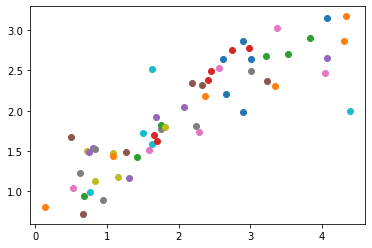

In [688]:
plt.show()  
for n in range(0,sampleFeatures.size().getInfo()) :
    actual = (ee.Feature(sampleFeaturesList.get(n)).get('LAICEV61_Total')).getInfo() 
    residual = np.array((dataCCRS2020[n]['sampleLAI3x3'])[2]['data'])/1000-actual
    residualAbs = np.absolute(residual)
    index = np.where(residualAbs<np.percentile(residualAbs,20))    
    estimate = actual + np.median(residual[index[0][0]])
    plt.plot(actual,estimate,'o')
    print(n,actual,estimate)
plt.show()  

0 0.7677099704742432 0.48053783910059245
1 0.8090350031852722 0.5306356132374317
2 0.8260359764099121 0.5432608962848118
3 0.5768499970436096 0.3701645430988297
4 0.6498759984970093 0.3951024667078686
5 0.2387620061635971 0.28935769400004074
6 0.7413399815559387 0.6064362544063058
7 0.5890600085258484 0.3482790358160725
8 0.547514021396637 0.3871678091360539
9 0.46957600116729736 0.39130122887364094
10 0.6547330021858215 0.3493032777201157
11 0.6123039722442627 0.4412521387572453
12 0.6353650093078613 0.4065911242992112
13 0.6145150065422058 0.4320450389588161
14 0.6221200227737427 0.41471567876368015
15 0.6838489770889282 0.4690482580658406
16 0.26720499992370605 0.25586213242332445
17 0.3190000057220459 0.30861749716873327
18 0.2186640053987503 0.21021317280734464
19 0.392060786485672 0.3664867853900752
20 0.8983179926872253 0.596669822223653
21 0.07763499766588211 0.13658191704221992
22 0.43700000643730164 0.46288757745200426
23 0.7243480086326599 0.466154777993667
24 0.370797991752

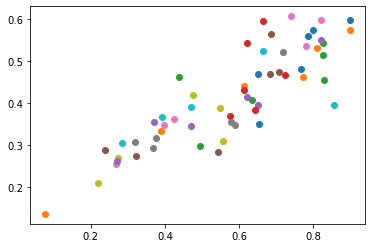

In [79]:
plt.show()  
for n in range(0,sampleFeatures.size().getInfo()) :
    actual = (ee.Feature(sampleFeaturesList.get(n)).get('fcover_Total')).getInfo() 
    residual = np.array((dataCCRS2020[n]['samplefCOVER3x3'])[2]['data'])/1000-actual
    residualAbs = np.absolute(residual)
    index = np.where(residualAbs<np.percentile(residualAbs,20))    
    estimate = actual + np.median(residual[index[0][0]])
    plt.plot(actual,estimate,'o')
    print(n,actual,estimate)
plt.show() 

0 0.7885000109672546 0.4781190550115461
1 0.9142000079154968 0.5279030378905903
2 0.8745999932289124 0.5402170132840833
3 0.6924999952316284 0.37287849029939346
4 0.7368000149726868 0.39913787786759997
5 0.3118000030517578 0.2880017720725404
6 0.8119000196456909 0.5947002066311198
7 0.621999979019165 0.3538359972820652
8 0.5906000137329102 0.3871658538003511
9 0.5920000076293945 0.3942088359414496
10 0.8039000034332275 0.3549411657180701
11 0.7458000183105469 0.44285745398383203
12 0.6687999963760376 0.40895863221754547
13 0.737500011920929 0.43137539534864316
14 0.6863999962806702 0.41281206359111805
15 0.73089998960495 0.46797254387803583
16 0.3100000023841858 0.2968563782890826
17 0.4300000071525574 0.3183071528915027
18 0.3824999928474426 0.29231097604469775
19 0.4300000071525574 0.3931904953639319
20 0.9160000085830688 0.5846578080550904
21 0.09910000115633011 0.14100898523782632
22 0.41589999198913574 0.3863104403030009
23 0.7854999899864197 0.44454166064042283
24 0.4490000009536

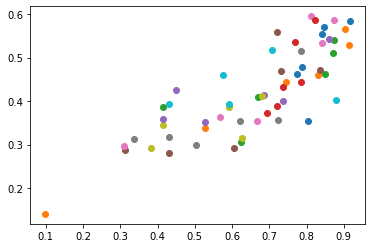

In [81]:
plt.show()  
for n in range(0,sampleFeatures.size().getInfo()) :
    actual = (ee.Feature(sampleFeaturesList.get(n)).get('Daily_Integrated_Black_Sky_fAPAR_Total')).getInfo() 
    residual = np.array((dataCCRS2020[n]['samplefAPAR3x3'])[2]['data'])/1000-actual
    residualAbs = np.absolute(residual)
    index = np.where(residualAbs<np.percentile(residualAbs,20))    
    estimate = actual + np.median(residual[index[0][0]])
    plt.plot(actual,estimate,'o')
    print(n,actual,estimate)
plt.show() 

In [85]:
# input parameters
plotFeatures = ee.FeatureCollection("users/hemitshah/WP3/CCRSInSituLAI2019").map(lambda feature: feature.buffer(100))
sampleFeatures = ee.FeatureCollection("users/hemitshah/WP3/CCRSInSituLAI2019").map(lambda feature: feature.buffer(60))


# collection name
colName = "COPERNICUS/S2_SR"

# product name, one of('Surface_Reflectance','Albedo','FAPAR','FCOVER','LAI','CCC','CWC','DASF')
outputName = "LAI"

# date range for inputs
startDate = ee.Date('2020-07-01')
endDate = ee.Date('2020-08-31')

# geographical bounds of inputs you can specify a JSON geometry (e.g. from earth engine)
mapBounds = plotFeatures.geometry()

# other filters - for now only cloud cover
maxCloudcover = 90


# parse the networks
colOptions = COLLECTION_OPTIONS[colName]
netOptions = VIS_OPTIONS[outputName][colName]
numNets = ee.Number(ee.Feature((COLLECTION_OPTIONS[colName]["Network_Ind"]).first()).propertyNames().remove('Feature Index').remove('system:index').remove('lon').size())
#SL2P1 = makeNetVars2(COLLECTION_OPTIONS[colName]["Collection_SL2P"],numNets,1)
SL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2P"],numNets,netNum));
errorsSL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2Perrors"],numNets,netNum));

In [86]:
# make products 
input_collection =  ee.ImageCollection(colName) \
                      .filterBounds(mapBounds) \
                      .filterDate(startDate, endDate) \
                      .filterMetadata(colOptions["Cloudcover"],'less_than',maxCloudcover) \
                      .limit(5000) \
                      .map(lambda image: addDate(image)) \
                      .map(lambda image: image.clip(mapBounds)) \
                      .map(lambda image: s2MaskClear(image)) \
                      .map(lambda image: addS2Geometry(colOptions,image))
print(input_collection.size().getInfo())

if outputName == "Surface_Reflectance":
    export_collection = input_collection;
    displayImage(export_collection.mosaic().select("B3"),0,4000)    
else:
    # get partition used to select network
    partition = (COLLECTION_OPTIONS[colName]["partition"]).filterBounds(mapBounds).mosaic().clip(mapBounds).rename('partition');
    # pre process input imagery and flag invalid inputs
    input_collection  =  input_collection.map(lambda image: s2MaskLand(image)) \
                                         .map(lambda image: scaleBands(netOptions["inputBands"],netOptions["inputScaling"],image)) \
                                         .map(lambda image: invalidInput(COLLECTION_OPTIONS[colName]["sl2pDomain"],netOptions["inputBands"],image))
    ## apply networks to produce mapped parameters
    estimateSL2P = input_collection.map(lambda image: wrapperNNets(SL2P,partition, netOptions, COLLECTION_OPTIONS[colName],"estimate",image))
    uncertaintySL2P = input_collection.map(lambda image: wrapperNNets(errorsSL2P,partition, netOptions, COLLECTION_OPTIONS[colName],"error",image))
    # scale and offset mapped parameter bands
    estimateSL2P = estimateSL2P.map(lambda image: image.addBands(image.select("estimate"+outputName).multiply(ee.Image.constant(outputScale)).add(ee.Image.constant(outputOffset)),overwrite=True));
    uncertaintySL2P = uncertaintySL2P.map(lambda image: image.addBands(image.select("error"+outputName).multiply(ee.Image.constant(outputScale)).add(ee.Image.constant(outputOffset)),overwrite=True));
    # produce final collection
    export_collection =  input_collection.select(['date','QC']).combine(estimateSL2P).combine(uncertaintySL2P)




390


In [87]:
# extract product values for each image for a feature
scaleSample = 20
filterSize = 60
image= export_collection.mosaic()
sampleFeatures = sampleFeatures.map( lambda sampleRegion: sampleProduct(image, scaleSample, filterSize, sampleRegion,'sampleLAI3x3'))

In [91]:
# input parameters
# collection name
colName = "COPERNICUS/S2_SR"

# product name, one of('Surface_Reflectance','Albedo','FAPAR','FCOVER','LAI','CCC','CWC','DASF')
outputName = "fAPAR"

# date range for inputs
startDate = ee.Date('2020-07-01')
endDate = ee.Date('2020-08-31')
# geographical bounds of inputs you can specify a JSON geometry (e.g. from earth engine)
#sampleFeatures = ee.FeatureCollection("users/hemitshah/WP3/CCRSInSituLAI2020").map(lambda feature: feature.buffer(100))
mapBounds = sampleFeatures.geometry()

# other filters - for now only cloud cover
maxCloudcover = 90

# Output parameters , outputScale and outputOffset not applied to "Surface_Reflectance"
outputScale = 1000;
outputOffset = 0;
exportFolder="users/hemitshah/ExportedData"
exportScale = 20
exportDatatype = "int"

# parse the networks
colOptions = COLLECTION_OPTIONS[colName]
netOptions = VIS_OPTIONS[outputName][colName]
numNets = ee.Number(ee.Feature((COLLECTION_OPTIONS[colName]["Network_Ind"]).first()).propertyNames().remove('Feature Index').remove('system:index').remove('lon').size())
#SL2P1 = makeNetVars2(COLLECTION_OPTIONS[colName]["Collection_SL2P"],numNets,1)
SL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2P"],numNets,netNum));
errorsSL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2Perrors"],numNets,netNum));

In [92]:
# make products 
input_collection =  ee.ImageCollection(colName) \
                      .filterBounds(mapBounds) \
                      .filterDate(startDate, endDate) \
                      .filterMetadata(colOptions["Cloudcover"],'less_than',maxCloudcover) \
                      .limit(5000) \
                      .map(lambda image: addDate(image)) \
                      .map(lambda image: image.clip(mapBounds)) \
                      .map(lambda image: s2MaskClear(image)) \
                      .map(lambda image: addS2Geometry(colOptions,image))
print(input_collection.size().getInfo())

if outputName == "Surface_Reflectance":
    export_collection = input_collection;
    displayImage(export_collection.mosaic().select("B3"),0,4000)    
else:
    # get partition used to select network
    partition = (COLLECTION_OPTIONS[colName]["partition"]).filterBounds(mapBounds).mosaic().clip(mapBounds).rename('partition');
    # pre process input imagery and flag invalid inputs
    input_collection  =  input_collection.map(lambda image: s2MaskLand(image)) \
                                         .map(lambda image: scaleBands(netOptions["inputBands"],netOptions["inputScaling"],image)) \
                                         .map(lambda image: invalidInput(COLLECTION_OPTIONS[colName]["sl2pDomain"],netOptions["inputBands"],image))
    ## apply networks to produce mapped parameters
    estimateSL2P = input_collection.map(lambda image: wrapperNNets(SL2P,partition, netOptions, COLLECTION_OPTIONS[colName],"estimate",image))
    uncertaintySL2P = input_collection.map(lambda image: wrapperNNets(errorsSL2P,partition, netOptions, COLLECTION_OPTIONS[colName],"error",image))
    # scale and offset mapped parameter bands
    estimateSL2P = estimateSL2P.map(lambda image: image.addBands(image.select("estimate"+outputName).multiply(ee.Image.constant(outputScale)).add(ee.Image.constant(outputOffset)),overwrite=True));
    uncertaintySL2P = uncertaintySL2P.map(lambda image: image.addBands(image.select("error"+outputName).multiply(ee.Image.constant(outputScale)).add(ee.Image.constant(outputOffset)),overwrite=True));
    # produce final export collection
    export_collection =  input_collection.select(['date','QC']).combine(estimateSL2P).combine(uncertaintySL2P)
    #displayImage(export_collection.mosaic().select("estimate"+outputName),0+outputOffset,1*outputScale+outputOffset)    
#image_output_names = ([name+"_"+outputName for name in export_collection.toList(export_collection.size()).map(lambda image: ee.Image(image).id()).getInfo()])


390


In [ ]:
# extract product values for each image for a feature
scaleSample = 20
filterSize = 60
image= export_collection.mosaic()
sampleFeatures = sampleFeatures.map( lambda sampleRegion: sampleProduct(image, scaleSample, filterSize, sampleRegion,'samplefAPAR3x3'))

In [ ]:
# input parameters
# collection name
colName = "COPERNICUS/S2_SR"

# product name, one of('Surface_Reflectance','Albedo','FAPAR','FCOVER','LAI','CCC','CWC','DASF')
outputName = "fCOVER"

# date range for inputs
startDate = ee.Date('2020-07-01')
endDate = ee.Date('2020-08-31')
# geographical bounds of inputs you can specify a JSON geometry (e.g. from earth engine)
#sampleFeatures = ee.FeatureCollection("users/hemitshah/WP3/CCRSInSituLAI2020").map(lambda feature: feature.buffer(100))
mapBounds = sampleFeatures.geometry()

# other filters - for now only cloud cover
maxCloudcover = 90

# Output parameters , outputScale and outputOffset not applied to "Surface_Reflectance"
outputScale = 1000;
outputOffset = 0;
exportFolder="users/hemitshah/ExportedData"
exportScale = 20
exportDatatype = "int"

# parse the networks
colOptions = COLLECTION_OPTIONS[colName]
netOptions = VIS_OPTIONS[outputName][colName]
numNets = ee.Number(ee.Feature((COLLECTION_OPTIONS[colName]["Network_Ind"]).first()).propertyNames().remove('Feature Index').remove('system:index').remove('lon').size())
#SL2P1 = makeNetVars2(COLLECTION_OPTIONS[colName]["Collection_SL2P"],numNets,1)
SL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2P"],numNets,netNum));
errorsSL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2Perrors"],numNets,netNum));

In [ ]:
# make products 
input_collection =  ee.ImageCollection(colName) \
                      .filterBounds(mapBounds) \
                      .filterDate(startDate, endDate) \
                      .filterMetadata(colOptions["Cloudcover"],'less_than',maxCloudcover) \
                      .limit(5000) \
                      .map(lambda image: addDate(image)) \
                      .map(lambda image: image.clip(mapBounds)) \
                      .map(lambda image: s2MaskClear(image)) \
                      .map(lambda image: addS2Geometry(colOptions,image))
print(input_collection.size().getInfo())

if outputName == "Surface_Reflectance":
    export_collection = input_collection;
    displayImage(export_collection.mosaic().select("B3"),0,4000)    
else:
    # get partition used to select network
    partition = (COLLECTION_OPTIONS[colName]["partition"]).filterBounds(mapBounds).mosaic().clip(mapBounds).rename('partition');
    # pre process input imagery and flag invalid inputs
    input_collection  =  input_collection.map(lambda image: s2MaskLand(image)) \
                                         .map(lambda image: scaleBands(netOptions["inputBands"],netOptions["inputScaling"],image)) \
                                         .map(lambda image: invalidInput(COLLECTION_OPTIONS[colName]["sl2pDomain"],netOptions["inputBands"],image))
    ## apply networks to produce mapped parameters
    estimateSL2P = input_collection.map(lambda image: wrapperNNets(SL2P,partition, netOptions, COLLECTION_OPTIONS[colName],"estimate",image))
    uncertaintySL2P = input_collection.map(lambda image: wrapperNNets(errorsSL2P,partition, netOptions, COLLECTION_OPTIONS[colName],"error",image))
    # scale and offset mapped parameter bands
    estimateSL2P = estimateSL2P.map(lambda image: image.addBands(image.select("estimate"+outputName).multiply(ee.Image.constant(outputScale)).add(ee.Image.constant(outputOffset)),overwrite=True));
    uncertaintySL2P = uncertaintySL2P.map(lambda image: image.addBands(image.select("error"+outputName).multiply(ee.Image.constant(outputScale)).add(ee.Image.constant(outputOffset)),overwrite=True));
    # produce final export collection
    export_collection =  input_collection.select(['date','QC']).combine(estimateSL2P).combine(uncertaintySL2P)
    #displayImage(export_collection.mosaic().select("estimate"+outputName),0+outputOffset,1*outputScale+outputOffset)    
image_output_names = ([name+"_"+outputName for name in export_collection.toList(export_collection.size()).map(lambda image: ee.Image(image).id()).getInfo()])



In [ ]:
# extract product values for each image for a feature
scaleSample = 20
filterSize = 60
image= export_collection.mosaic()
sampleFeatures = sampleFeatures.map( lambda sampleRegion: sampleProduct(image, scaleSample, filterSize, sampleRegion,'samplefCOVER3x3'))

In [ ]:
dataCCRS2019 = []               
sampleFeaturesList =ee.List(sampleFeatures.toList(sampleFeatures.size()))
for n in range(0,sampleFeatures.size().getInfo()) :
    print(n)
    dataCCRS2019.append((ee.Dictionary(ee.Feature(sampleFeaturesList.get(n)).toDictionary())).getInfo())    


In [ ]:
plt.show()  
for n in range(0,sampleFeatures.size().getInfo()) :
    actual = (ee.Feature(sampleFeaturesList.get(n)).get('LAICEV61_Total')).getInfo() 
    residual = np.array((dataCCRS2019[n]['sampleLAI3x3'])[2]['data'])/1000-actual
    residualAbs = np.absolute(residual)
    index = np.where(residualAbs<np.percentile(residualAbs,20))    
    estimate = actual + np.median(residual[index[0][0]])
    plt.plot(actual,estimate,'o')
    print(n,actual,estimate)
plt.show()  

In [ ]:
plt.show()  
for n in range(0,sampleFeatures.size().getInfo()) :
    actual = (ee.Feature(sampleFeaturesList.get(n)).get('fcover_Total')).getInfo() 
    residual = np.array((dataLAI2019[n]['samplefCOVER3x3'])[2]['data'])/1000-actual
    residualAbs = np.absolute(residual)
    index = np.where(residualAbs<np.percentile(residualAbs,20))    
    estimate = actual + np.median(residual[index[0][0]])
    plt.plot(actual,estimate,'o')
    print(n,actual,estimate)
plt.show() 

In [ ]:
plt.show()  
for n in range(0,sampleFeatures.size().getInfo()) :
    actual = (ee.Feature(sampleFeaturesList.get(n)).get('Daily_Integrated_Black_Sky_fAPAR_Total')).getInfo() 
    residual = np.array((dataLAI2019[n]['samplefAPAR3x3'])[2]['data'])/1000-actual
    residualAbs = np.absolute(residual)
    index = np.where(residualAbs<np.percentile(residualAbs,20))    
    estimate = actual + np.median(residual[index[0][0]])
    plt.plot(actual,estimate,'o')
    print(n,actual,estimate)
plt.show() 